# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


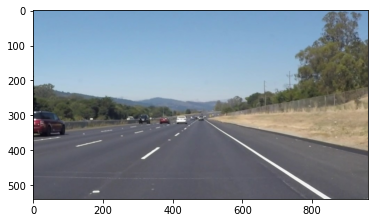

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_img(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns hough lines
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
## Helper methods
def getImages():
    '''Gets a list of images from the test_images directory'''
    images = []
    for imgPath in os.listdir("test_images/"):
        images.append(mpimg.imread('test_images/{}'.format(imgPath)))
    return images


def getRegionOfInterest(width, height, roiHeightRatio, roiLongWidthRatio, roiShortWidthRatio):
    '''Gets the region of interest of an image with the given image dimensions and roi ratios'''
    wideBorderX = width*(1-roiLongWidthRatio)/2
    narrowBorderX = width*(1-roiShortWidthRatio)/2
    yMax = height
    yMin = height * (1 - roiHeightRatio)
    return np.array([[(wideBorderX, yMax),
                      (narrowBorderX, yMin),
                      (width-narrowBorderX, yMin),
                      (width-wideBorderX, yMax),
                      (width-3*wideBorderX, yMax),
                      (width/2, (yMax+yMin)*1/2),
                      (3*wideBorderX, yMax),

                      ]], dtype=np.int32)


def displayImages(imagesByName):
    '''Display mid-process images'''
    fig, axs = plt.subplots(int((len(imagesByName)+1)/2), 2, figsize=(15, 10))
    fig.tight_layout()

    for i in range(len(imagesByName)):
        imageName, image = imagesByName[i]
        axs[int(i/2)][i%2].imshow(image) 
        axs[int(i/2)][i%2].set_title('{}'.format(imageName))

        
def filterLines(lines, width):
    '''Removes lines that do not have a valid slope for their location'''
    # Only keep lines that are sloped in the right direction
    # based on the side of the image that it is on
    filteredLines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Handle edge case
            if x1 == x2:
                filteredLines.append(line)
                continue

            slope = (y2-y1)/(x2-x1)
            centerX = (x2 + x1)/2
            isSlopeValidForLocation = (slope > 0.5 and centerX > width/2) or (slope < -0.5 and centerX < width/2)
            if isSlopeValidForLocation:
                filteredLines.append(line)
    return filteredLines


def findWeightedAverageSlopeAndIntercept(lines, directionHint='right'):
    if len(lines) == 0:
        print("Length of lines is 0. Giving back dummy values for slope and intercept")
        if directionHint == 'right':
            if hasattr(findWeightedAverageSlopeAndIntercept, 'lastPositiveSlopeIntercept'):
                return findWeightedAverageSlopeAndIntercept.lastPositiveSlopeIntercept
            return 0.6, 25
        else:
            if hasattr(findWeightedAverageSlopeAndIntercept, 'lastNegativeSlopeIntercept'):
                return findWeightedAverageSlopeAndIntercept.lastNegativeSlopeIntercept
            return -0.7, 640

    def calculateRhoAndTheta(m, b):
        theta = math.atan(-1/m)
        rho = b * math.sin(theta)
        return rho, theta
    
    def calculateSlopeAndIntercept(rho, theta):
        slope = -1/math.tan(theta)
        intercept = rho/math.sin(theta)
        return slope, intercept

    # Calculate weighted values
    totalRho = 0
    totalTheta = 0
    totalLength = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Handle edge case
            if x2 == x1:
                x2 += 0.001
                
            # Calculate rho and theta
            slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
            rho, theta = calculateRhoAndTheta(slope, intercept)
            
            # Get weighted values
            length = ((x2-x1)**2 + (y2-y1)**2)**0.5
            totalRho += rho*length
            totalTheta += theta*length
            totalLength += length
            
    avgRho = totalRho/totalLength
    avgTheta = totalTheta/totalLength
    avgSlope, avgIntercept = calculateSlopeAndIntercept(avgRho, avgTheta)
    
    # Cache recent values to be used if lines can't be found
    if avgSlope > 0:
        findWeightedAverageSlopeAndIntercept.lastPositiveSlopeIntercept = (avgSlope, avgIntercept)
    else:
        findWeightedAverageSlopeAndIntercept.lastNegativeSlopeIntercept = (avgSlope, avgIntercept)

    return avgSlope, avgIntercept

def convertToTwoLines(lines, width, yMax, yMin):
    '''Converts lines into two lines through averaging''' 

    def findLeftAndRightLines(lines):
        rightLines = []
        leftLines = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    rightLines.append(line)
                else:
                    leftLines.append(line)
        return leftLines, rightLines

    def createLine(m, b, y1, y2):
        x1 = int((y1-b)/m)
        x2 = int((y2-b)/m)
        y1 = int(y1)
        y2 = int(y2)
        return (x1, y1, x2, y2)

    # Get the average slope/intercept for the left and right line
    leftLines, rightLines = findLeftAndRightLines(lines)
    avgLeftSlope, avgLeftIntercept = findWeightedAverageSlopeAndIntercept(leftLines, 'left')
    avgRightSlope, avgRightIntercept = findWeightedAverageSlopeAndIntercept(rightLines, 'right')

    # Return the lines
    leftLine = createLine(avgLeftSlope, avgLeftIntercept, yMax, yMin)
    rightLine = createLine(avgRightSlope, avgRightIntercept, yMax, yMin)
    return [[leftLine], [rightLine]]

def createLineImage(lines, height, width, channels):
    linesImage = np.zeros((height, width, channels), dtype=np.uint8)
    draw_lines(linesImage, lines, thickness=5)
    return linesImage

In [100]:
def process_image(image, displayMidProcessImages=False, averageRecentLines=True):
    """Finds lane lines of the image and returns the original image with the lane lines added."""
    
    ## Tunable parameters
    kernelSize = 5  # Must be odd. Eg. 3, 5, 7
    
    lowThreshold = 10
    highThreshold = 120
    
    roiHeightRatio = 40/100
    roiLongWidthRatio = 90/100
    roiShortWidthRatio = 4/100
    
    rho = 2
    theta = np.pi / 180
    threshold = 30
    minLineLen = 15
    maxLineGap = 10
    
    # Calculations which will be useful for future parts
    height, width, channels = image.shape
    
    # Step 1: Convert to grayscale for proper edge detection
    grayImage = grayscale(image)

    # Step 2: Perform Gaussian Blur to remove noise
    blurredGrayImage = gaussian_blur(grayImage, kernelSize)

    # Step 3: Perform Canny edge detection
    edgesImage = canny(blurredGrayImage, lowThreshold, highThreshold)
    
    # Step 4: Only look at region of interest
    roi = getRegionOfInterest(width, height, roiHeightRatio, roiLongWidthRatio, roiShortWidthRatio)
    edgesImageRoi = region_of_interest(edgesImage, roi)
    
    # Step 5: Find lines with hough transform
    houghLines = hough_lines(edgesImageRoi, rho, theta, threshold, minLineLen, maxLineGap)
    
    # Step 6: Filter the hough lines
    filteredLines = filterLines(houghLines, width)
    filteredLinesImage = createLineImage(filteredLines, height, width, channels)

    # Step 7: Convert the filtered hough lines to two lines by averaging
    twoLines = convertToTwoLines(filteredLines, width, height, height * (1 - roiHeightRatio))
    twoLinesImage = createLineImage(twoLines, height, width, channels)
    
    # Addition
    # First time
    if not hasattr(process_image, 'count'):
        process_image.count = 0
    else:
        process_image.count += 1
        print(process_image.count)
        
    import time
    if not hasattr(process_image, 'lastTime'):
        print("Handling first time lastTime")
        process_image.lastTime = time.time()
    else:
        if time.time() - process_image.lastTime > 0.1:
            print("Reset lastTwoLines because of time")
            process_image.lastTwoLines = []
        else:
            print("Not reset lastTwoLines, time is ok")
        process_image.lastTime = time.time()


    # First time
    if not hasattr(process_image, 'lastTwoLines'):
        print("Handling first time lastTwoLines")
        process_image.lastTwoLines = twoLines
    else:
        # Average over last 10 at most
        if len(process_image.lastTwoLines) >= 10:
            print("lastTwoLines long, removing two")
            process_image.lastTwoLines.pop(0)
            process_image.lastTwoLines.pop(0)
        else:
            print("lastTwoLines not at cap")

        process_image.lastTwoLines += twoLines
        print("Adding in twoLines")

    
    twoLines = convertToTwoLines(process_image.lastTwoLines, width, height, height * (1 - roiHeightRatio))
    twoLinesImage = createLineImage(twoLines, height, width, channels)

    allLinesImage = createLineImage(filteredLines, height, width, channels)
    draw_lines(allLinesImage, twoLines, color=[0,255,0], thickness=5)

    # Step 8: Draw lines on original image
    processedImage = weighted_img(twoLinesImage, image, α=.7, β=1.)

    # Display images in process, if desired
    if displayMidProcessImages:
        imagesByName = [('grayImage', grayImage),
                        ('blurredGrayImage', blurredGrayImage),
                        ('edgesImage', edgesImage),
                        ('edgesImageRoi', edgesImageRoi),
                        ('filteredLinesImage', filteredLinesImage),
                        ('twoLinesImage', twoLinesImage),
                        ('allLinesImage', allLinesImage),
                        ('processedImage', processedImage)
                       ]
        displayImages(imagesByName)

    return processedImage

Handling first time lastTime
Handling first time lastTwoLines


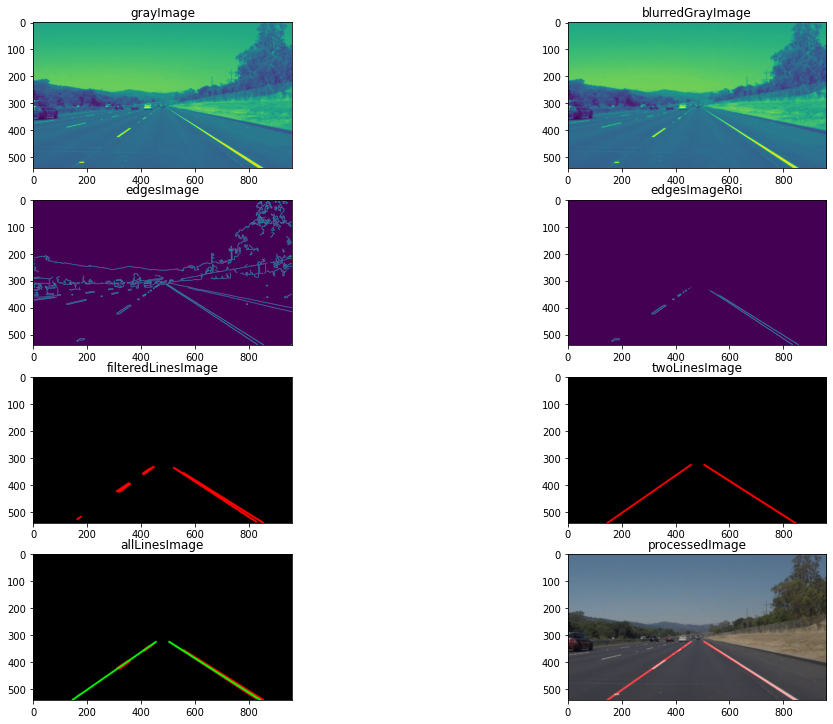

In [101]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = getImages()

processedImage = process_image(images[2], displayMidProcessImages=True)

1
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
2
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
3
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
4
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
5
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
6
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines


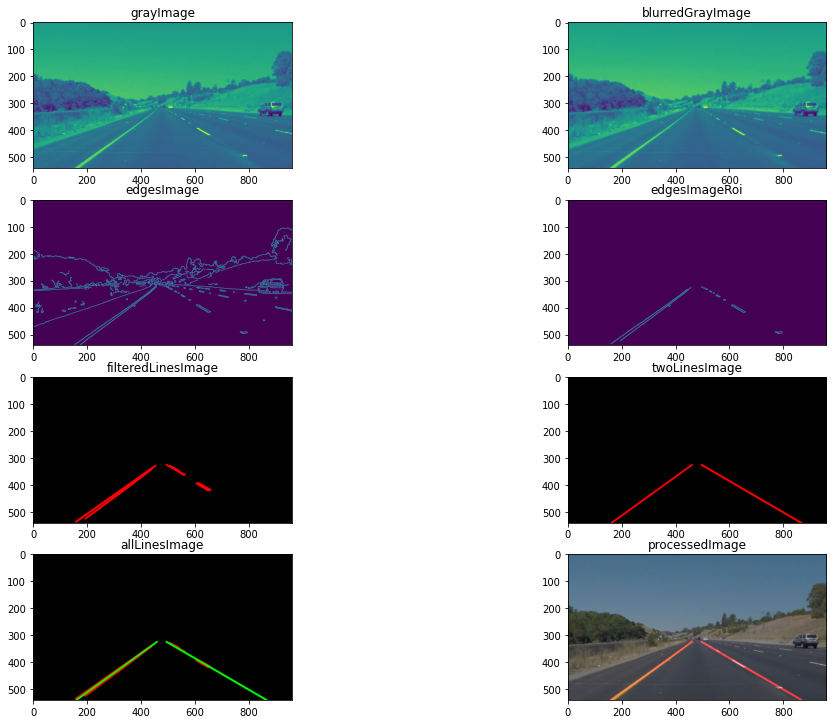

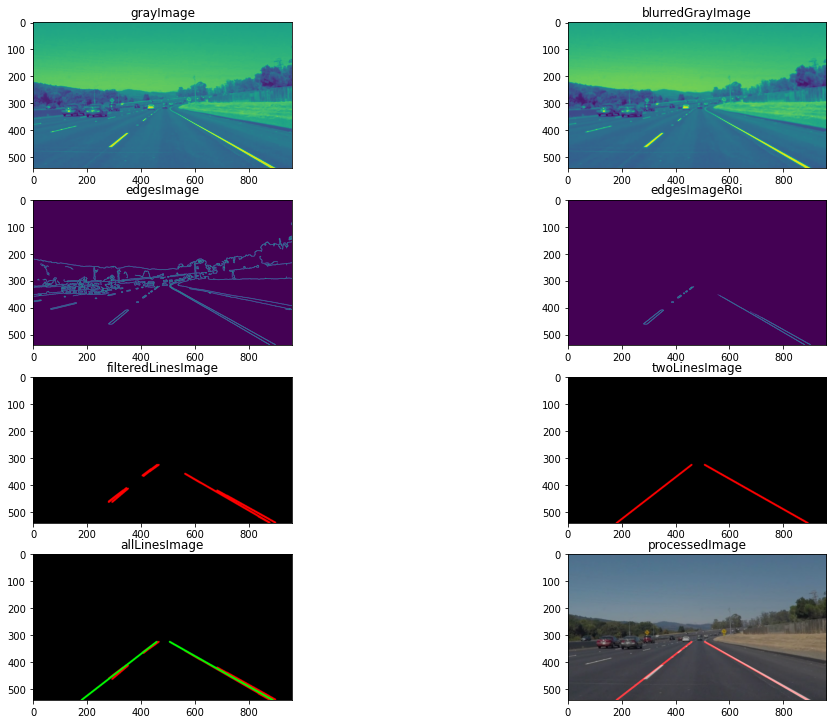

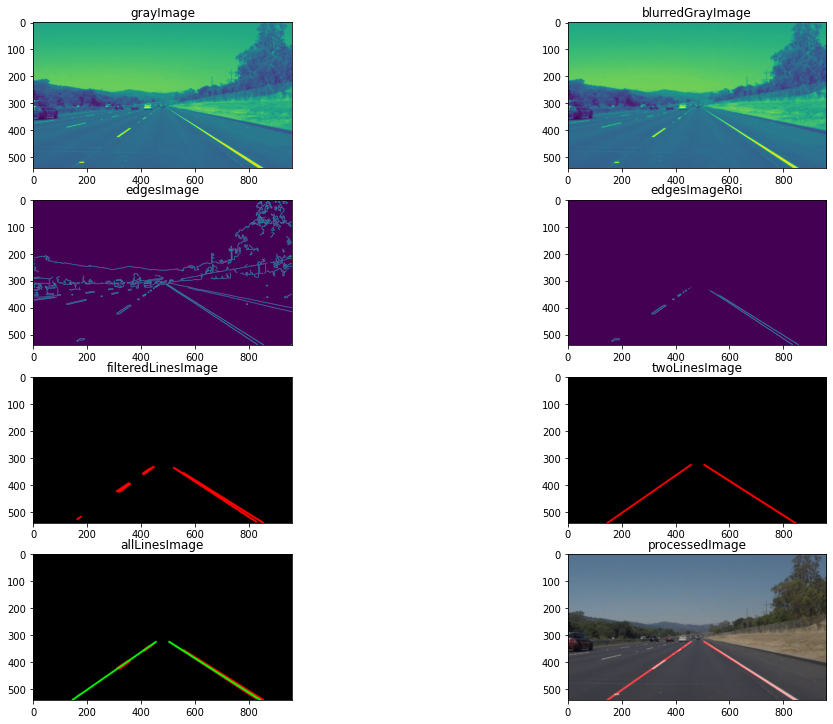

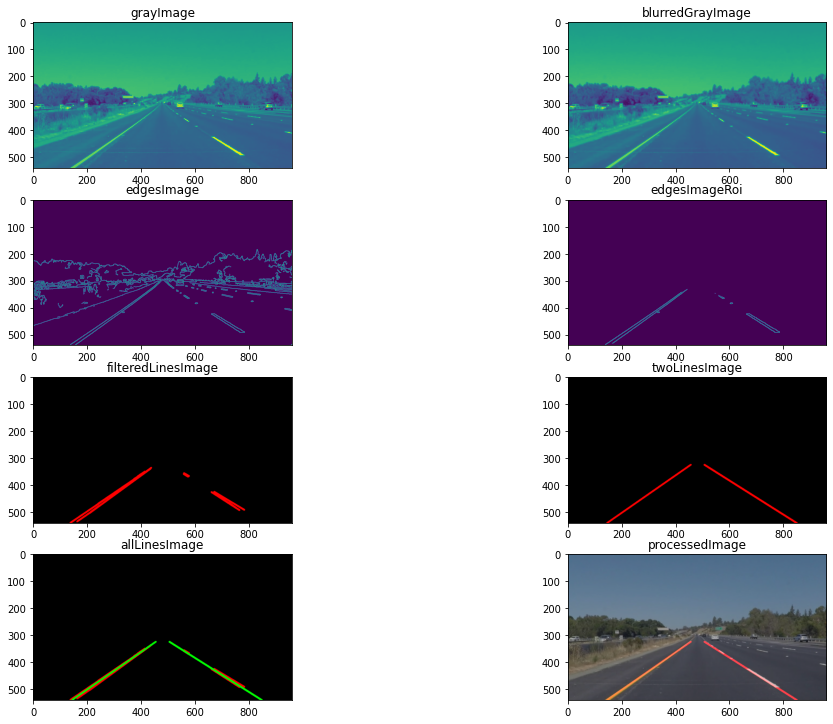

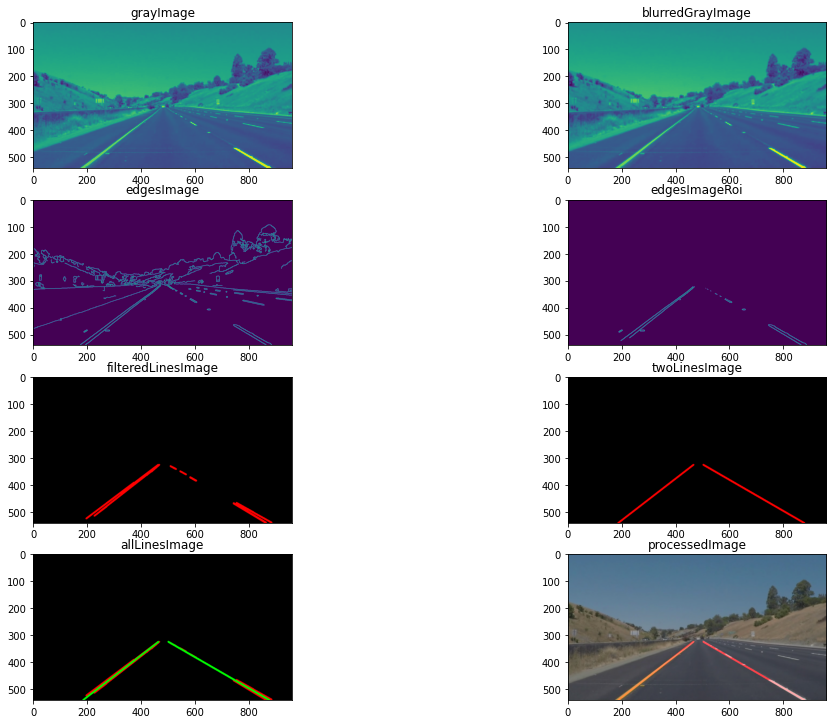

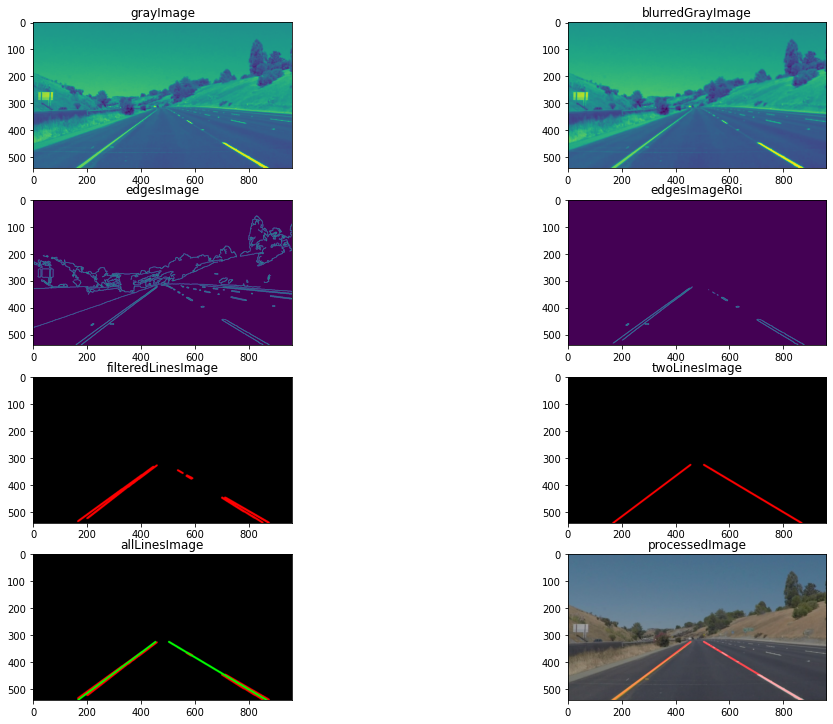

In [102]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = getImages()

for image in images:
    processedImage = process_image(image, displayMidProcessImages=True, averageRecentLines=False)

7
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
8
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
9
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
10
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
11
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
12
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


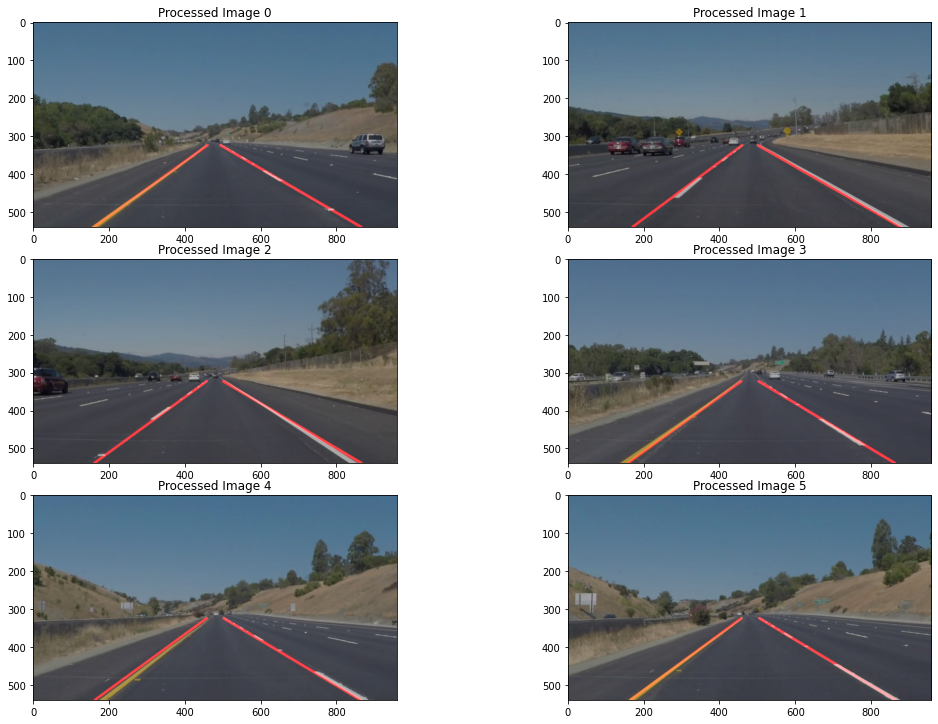

In [93]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = getImages()

fig, axs = plt.subplots(int((len(images)+1)/2), 2, figsize=(15, 10))
fig.tight_layout()

for i in range(len(images)):
    image = images[i]
    processedImage = process_image(image)
    axs[int(i/2)][i%2].imshow(processedImage, averageRecentLines=False) 
    axs[int(i/2)][i%2].set_title('Processed Image {}'.format(i))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [96]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▌         | 12/221 [00:00<00:01, 114.52it/s, now=None]

265
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

266
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
267
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
268
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
269
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
270
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
271
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
272
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
273
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
274
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
275
Not res

t:  17%|█▋        | 38/221 [00:00<00:01, 118.35it/s, now=None]

287
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
288
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
289
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
290
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
291
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
292
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
293
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
294
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
295
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
296
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
297
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
298
Not re

t:  27%|██▋       | 59/221 [00:00<00:01, 102.79it/s, now=None]

312
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
313
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
314
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
315
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
316
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
317
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
318
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
319
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
320
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
321
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
322
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
323
Not re

t:  35%|███▌      | 78/221 [00:00<00:01, 96.19it/s, now=None] 

328
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
329
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
330
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
331
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
332
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
333
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
334
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
335
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
336
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
337
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
338
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
339
Not re

t:  43%|████▎     | 96/221 [00:00<00:01, 90.74it/s, now=None]

347
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
348
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
349
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
350
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
351
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
352
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
353
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
354
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
355
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
356
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
357
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
358
Not re

t:  52%|█████▏    | 114/221 [00:01<00:01, 84.52it/s, now=None]

365
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
366
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
367
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
368
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
369
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
370
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
371
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
372
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
373
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
374
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
375
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
376
Not re

t:  60%|█████▉    | 132/221 [00:01<00:01, 82.67it/s, now=None]

382
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
383
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
384
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
385
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
386
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
387
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
388
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
389
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
390
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
391
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
392
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
393
Not re

t:  68%|██████▊   | 150/221 [00:01<00:00, 81.08it/s, now=None]

399
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
400
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
401
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
402
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
403
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
404
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
405
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
406
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
407
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
408
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
409
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
410
Not re

t:  72%|███████▏  | 159/221 [00:01<00:00, 78.69it/s, now=None]

415
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
416
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
417
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
418
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
419
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
420
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
421
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
422
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
423
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
424
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
425
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
426
Not re

t:  80%|████████  | 177/221 [00:02<00:00, 76.98it/s, now=None]

432
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
433
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
434
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
435
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
436
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
437
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
438
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
439
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
440
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
441
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
442
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
443
Not re

t:  88%|████████▊ | 195/221 [00:02<00:00, 79.46it/s, now=None]

446
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
447
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
448
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
449
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
450
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
451
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
452
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
453
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
454
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
455
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
456
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
457
Not re

t:  97%|█████████▋| 214/221 [00:02<00:00, 86.50it/s, now=None]

465
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
466
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
467
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
468
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
469
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
470
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
471
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
472
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
473
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
474
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
475
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
476
Not re

485
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
486
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 6.89 s, sys: 216 ms, total: 7.11 s
Wall time: 2.74 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [98]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 13/681 [00:00<00:05, 120.57it/s, now=None]

487
Reset lastTwoLines because of time
lastTwoLines not at cap
Adding in twoLines
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

488
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
489
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
490
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
491
Not reset lastTwoLines, time is ok
lastTwoLines not at cap
Adding in twoLines
492
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
493
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
494
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
495
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
496
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
497
Not res

t:   6%|▌         | 38/681 [00:00<00:05, 120.39it/s, now=None]

510
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
511
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
512
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
513
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
514
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
515
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
516
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
517
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
518
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
519
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
520
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
521
Not re

t:   9%|▊         | 58/681 [00:00<00:06, 100.66it/s, now=None]

534
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
535
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
536
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
537
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
538
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
539
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
540
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
541
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
542
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
543
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
544
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
545
Not re

t:  11%|█▏        | 78/681 [00:00<00:06, 96.48it/s, now=None] 

549
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
550
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
551
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
552
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
553
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
554
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
555
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
556
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
557
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
558
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
559
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
560
Not re

t:  14%|█▍        | 97/681 [00:00<00:06, 92.82it/s, now=None]

568
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
569
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
570
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
571
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
572
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
573
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
574
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
575
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
576
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
577
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
578
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
579
Not re

t:  17%|█▋        | 117/681 [00:01<00:05, 95.47it/s, now=None]

587
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
588
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
589
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
590
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
591
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
592
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
593
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
594
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
595
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
596
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
597
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
598
Not re

t:  20%|██        | 137/681 [00:01<00:05, 94.40it/s, now=None]

607
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
608
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
609
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
610
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
611
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
612
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
613
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
614
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
615
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
616
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
617
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
618
Not re

t:  23%|██▎       | 157/681 [00:01<00:05, 93.47it/s, now=None]

626
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
627
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
628
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
629
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
630
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
631
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
632
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
633
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
634
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
635
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
636
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
637
Not re

t:  26%|██▌       | 177/681 [00:01<00:05, 90.70it/s, now=None]

646
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
647
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
648
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
649
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
650
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
651
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
652
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
653
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
654
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
655
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
656
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
657
Not re

t:  27%|██▋       | 187/681 [00:01<00:05, 91.69it/s, now=None]

664
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
665
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
666
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
667
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
668
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
669
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
670
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
671
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
672
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
673
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
674
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
675
Not re

t:  30%|███       | 207/681 [00:02<00:05, 89.50it/s, now=None]

683
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
684
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
685
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
686
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
687
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
688
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
689
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
690
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
691
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
692
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
693
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
694
Not re

t:  33%|███▎      | 225/681 [00:02<00:05, 85.91it/s, now=None]

701
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
702
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
703
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
704
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
705
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
706
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
707
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
708
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
709
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
710
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
711
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
712
Not re

t:  36%|███▌      | 244/681 [00:02<00:04, 88.15it/s, now=None]

719
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
720
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
721
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
722
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
723
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
724
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
725
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
726
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
727
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
728
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
729
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
730
Not re

t:  38%|███▊      | 262/681 [00:02<00:04, 88.20it/s, now=None]

737
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
738
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
739
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
740
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
741
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
742
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
743
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
744
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
745
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
746
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
747
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
748
Not re

t:  41%|████      | 280/681 [00:03<00:04, 87.59it/s, now=None]

755
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
756
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
757
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
758
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
759
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
760
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
761
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
762
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
763
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
764
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
765
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
766
Not re

t:  44%|████▍     | 298/681 [00:03<00:04, 84.33it/s, now=None]

773
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
774
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
775
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
776
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
777
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
778
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
779
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
780
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
781
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
782
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
783
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
784
Not re

t:  46%|████▋     | 316/681 [00:03<00:04, 81.26it/s, now=None]

789
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
790
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
791
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
792
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
793
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
794
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
795
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
796
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
797
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
798
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
799
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
800
Not re

t:  49%|████▉     | 336/681 [00:03<00:04, 85.82it/s, now=None]

805
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
806
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
807
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
808
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
809
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
810
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
811
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
812
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
813
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
814
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
815
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
816
Not re

t:  51%|█████     | 346/681 [00:03<00:03, 87.18it/s, now=None]

824
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
825
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
826
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
827
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
828
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
829
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
830
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
831
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
832
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
833
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
834
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
835
Not re

t:  53%|█████▎    | 364/681 [00:03<00:03, 86.60it/s, now=None]

842
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
843
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
844
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
845
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
846
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
847
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
848
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
849
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
850
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
851
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
852
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
853
Not re

t:  56%|█████▌    | 383/681 [00:04<00:03, 87.25it/s, now=None]

861
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
862
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
863
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
864
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
865
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
866
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
867
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
868
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
869
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
870
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
871
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
872
Not re

t:  59%|█████▉    | 403/681 [00:04<00:03, 88.73it/s, now=None]

880
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
881
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
882
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
883
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
884
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
885
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
886
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
887
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
888
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
889
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
890
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
891
Not re

t:  62%|██████▏   | 422/681 [00:04<00:02, 88.54it/s, now=None]

898
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
899
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
900
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
901
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
902
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
903
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
904
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
905
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
906
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
907
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
908
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
909
Not re

t:  65%|██████▍   | 441/681 [00:04<00:02, 87.61it/s, now=None]

917
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
918
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
919
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
920
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
921
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
922
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
923
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
924
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
925
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
926
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
927
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
928
Not re

t:  68%|██████▊   | 460/681 [00:05<00:02, 85.89it/s, now=None]

935
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
936
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
937
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
938
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
939
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
940
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
941
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
942
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
943
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
944
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
945
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
946
Not re

t:  70%|███████   | 479/681 [00:05<00:02, 86.88it/s, now=None]

953
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
954
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
955
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
956
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
957
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
958
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
959
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
960
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
961
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
962
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
963
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
964
Not re

t:  73%|███████▎  | 497/681 [00:05<00:02, 87.03it/s, now=None]

972
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
973
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
974
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
975
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
976
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
977
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
978
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
979
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
980
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
981
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
982
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
983
Not re

t:  76%|███████▌  | 515/681 [00:05<00:01, 85.63it/s, now=None]

989
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
990
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
991
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
992
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
993
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
994
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
995
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
996
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
997
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
998
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
999
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1000
Not r

t:  78%|███████▊  | 533/681 [00:05<00:01, 86.52it/s, now=None]

1007
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1008
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1009
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1010
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1011
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1012
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1013
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1014
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1015
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1016
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1017
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  81%|████████  | 551/681 [00:06<00:01, 73.83it/s, now=None]

1025
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1026
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1027
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1028
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1029
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1030
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1031
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1032
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1033
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1034
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1035
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  82%|████████▏ | 560/681 [00:06<00:01, 74.74it/s, now=None]

1038
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1039
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1040
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1041
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1042
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1043
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1044
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1045
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1046
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1047
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1048
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  85%|████████▍ | 577/681 [00:06<00:01, 77.83it/s, now=None]

1054
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1055
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1056
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1057
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1058
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1059
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1060
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1061
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1062
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1063
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1064
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  87%|████████▋ | 593/681 [00:06<00:01, 76.57it/s, now=None]

1071
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1072
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1073
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1074
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1075
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1076
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1077
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1078
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1079
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1080
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1081
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  89%|████████▉ | 609/681 [00:06<00:00, 77.50it/s, now=None]

1087
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1088
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1089
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1090
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1091
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1092
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1093
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1094
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1095
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1096
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1097
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  92%|█████████▏| 626/681 [00:07<00:00, 76.82it/s, now=None]

1104
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1105
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1106
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1107
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1108
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1109
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1110
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1111
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1112
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1113
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1114
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  94%|█████████▍| 642/681 [00:07<00:00, 71.61it/s, now=None]

1118
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1119
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1120
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1121
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1122
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1123
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1124
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1125
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1126
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1127
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1128
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  97%|█████████▋| 658/681 [00:07<00:00, 70.06it/s, now=None]

1133
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1134
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1135
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1136
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1137
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1138
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1139
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1140
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1141
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1142
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1143
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

t:  99%|█████████▉| 675/681 [00:07<00:00, 72.13it/s, now=None]

1147
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1148
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1149
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1150
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1151
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1152
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1153
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1154
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1155
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1156
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1157
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines

1163
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1164
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1165
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1166
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1167
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
1168
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 21 s, sys: 822 ms, total: 21.9 s
Wall time: 8.22 s


In [99]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [94]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   3%|▎         | 8/251 [00:00<00:03, 72.20it/s, now=None]

13
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

14
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
15
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
16
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
17
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
18
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
19
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
20
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
21
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
22
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in tw

t:   9%|▉         | 23/251 [00:00<00:03, 69.12it/s, now=None]

26
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
27
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
28
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
29
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
30
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
31
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
32
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
33
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
34
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
35
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
36
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
37
Not reset lastTwoL

t:  15%|█▍        | 37/251 [00:00<00:03, 67.78it/s, now=None]

41
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
42
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
43
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
44
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
45
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
46
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
47
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
48
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
49
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
50
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
51
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
52
Not reset lastTwoL

t:  20%|█▉        | 50/251 [00:00<00:03, 55.36it/s, now=None]

55
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
56
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
57
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
58
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
59
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
60
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
61
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
62
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
63
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  25%|██▍       | 62/251 [00:01<00:03, 53.25it/s, now=None]

64
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
65
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
66
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
67
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
68
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
69
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
70
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
71
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
72
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
73
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
74
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  27%|██▋       | 68/251 [00:01<00:03, 51.10it/s, now=None]

75
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
76
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
77
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
78
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
79
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
80
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
81
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
82
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
83
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
84
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
85
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  32%|███▏      | 80/251 [00:01<00:03, 50.73it/s, now=None]

86
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
87
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
88
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
89
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
90
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
91
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
92
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
93
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
94
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
95
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
96
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  37%|███▋      | 92/251 [00:01<00:03, 47.49it/s, now=None]

97
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
98
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
99
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
100
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
101
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
102
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
103
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
104
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
105
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  41%|████      | 102/251 [00:01<00:03, 45.81it/s, now=None]

106
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
107
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
108
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
109
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
110
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
111
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
112
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
113
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
114
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
115
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  43%|████▎     | 108/251 [00:02<00:02, 47.71it/s, now=None]

116
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
117
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
118
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
119
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
120
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
121
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
122
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
123
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
124
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
125
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  47%|████▋     | 118/251 [00:02<00:02, 45.98it/s, now=None]

126
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
127
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
128
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
129
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
130
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
131
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
132
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
133
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
134
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
135
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  53%|█████▎    | 133/251 [00:02<00:02, 45.11it/s, now=None]

Length of lines is 0. Giving back dummy values for slope and intercept
136
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
137
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
138
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
139
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
140
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
Length of lines is 0. Giving back dummy values for slope and intercept
141
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
Length of lines is 0. Giving back dummy values for slope and intercept
142
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
143
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
144
Not reset lastTwoLines, time is ok
lastTwoLines long, removing 

t:  55%|█████▍    | 138/251 [00:02<00:02, 43.02it/s, now=None]

146
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
147
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
148
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
149
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
150
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
151
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
152
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
153
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
154
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  59%|█████▉    | 148/251 [00:02<00:02, 42.35it/s, now=None]

155
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
156
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
157
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
158
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
159
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
160
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
161
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
162
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
163
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  63%|██████▎   | 158/251 [00:03<00:02, 43.24it/s, now=None]

164
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
165
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
166
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
167
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
168
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
169
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
170
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
171
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
172
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
173
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  67%|██████▋   | 168/251 [00:03<00:01, 44.93it/s, now=None]

174
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
175
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
176
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
177
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
178
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
179
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
180
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
181
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
182
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
183
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  71%|███████   | 178/251 [00:03<00:01, 44.96it/s, now=None]

184
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
185
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
186
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
187
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
188
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
189
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
190
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
191
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
192
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  75%|███████▍  | 188/251 [00:03<00:01, 44.03it/s, now=None]

193
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
194
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
195
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
196
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
197
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
198
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
199
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
200
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
201
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  79%|███████▉  | 198/251 [00:04<00:01, 43.62it/s, now=None]

202
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
203
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
204
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
205
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
206
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
207
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
208
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
209
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
210
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
211
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  83%|████████▎ | 208/251 [00:04<00:00, 45.53it/s, now=None]

212
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
213
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
214
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
215
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
216
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
217
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
218
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
219
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
220
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
221
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  87%|████████▋ | 219/251 [00:04<00:00, 46.27it/s, now=None]

222
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
223
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
224
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
225
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
226
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
227
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
228
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
229
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
230
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
231
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  90%|████████▉ | 225/251 [00:04<00:00, 46.98it/s, now=None]

232
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
233
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
234
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
235
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
236
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
237
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
238
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
239
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
240
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
241
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  94%|█████████▎| 235/251 [00:04<00:00, 46.78it/s, now=None]

242
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
243
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
244
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
245
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
246
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
247
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
248
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
249
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
250
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
251
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


t:  98%|█████████▊| 246/251 [00:05<00:00, 48.12it/s, now=None]

252
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
253
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
254
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
255
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
256
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
257
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
258
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
259
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
260
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
261
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines


262
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
263
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
264
Not reset lastTwoLines, time is ok
lastTwoLines long, removing two
Adding in twoLines
Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 12.5 s, sys: 721 ms, total: 13.2 s
Wall time: 5.64 s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))